In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os

EVALUATION_FOLDER = "final_evaluation"
RESULTS_FILE_11 = "evaluation_minbzk_no_requests_minbzk_BM25S.csv"
RESULTS_FILE_12 = "evaluation_minbzk_no_requests_minbzk_bert-base-dutch-cased.csv"
RESULTS_FILE_13 = "evaluation_minbzk_no_requests_minbzk_all-MiniLM-L6-v2.csv"

RESULTS_FILE_21 = "evaluation_minaz_no_requests_minaz_BM25S.csv"
RESULTS_FILE_22 = "evaluation_minaz_no_requests_minaz_bert-base-dutch-cased.csv"
RESULTS_FILE_23 = "evaluation_minaz_no_requests_minaz_all-MiniLM-L6-v2.csv"

RESULTS_FILE_31 = "evaluation_minbuza_no_requests_minbuza_BM25S.csv"
RESULTS_FILE_32 = "evaluation_minbuza_no_requests_minbuza_bert-base-dutch-cased.csv"
RESULTS_FILE_33 = "evaluation_minbuza_no_requests_minbuza_all-MiniLM-L6-v2.csv"

RESULTS_FILE_41 = "evaluation_minfin_no_requests_minfin_BM25S.csv"
RESULTS_FILE_42 = "evaluation_minfin_no_requests_minfin_bert-base-dutch-cased.csv"
RESULTS_FILE_43 = "evaluation_minfin_no_requests_minfin_all-MiniLM-L6-v2.csv"

RESULTS_FILE_51 = "evaluation_minjenv_no_requests_minjenv_BM25S.csv"
RESULTS_FILE_52 = "evaluation_minjenv_no_requests_minjenv_bert-base-dutch-cased.csv"
RESULTS_FILE_53 = "evaluation_minjenv_no_requests_minjenv_all-MiniLM-L6-v2.csv"


SAVE_FOLDER = os.path.join("final_plots", "aggregate")
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

woo_data_11 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_11}")
woo_data_12 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_12}")
woo_data_13 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_13}")

woo_data_21 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_21}")
woo_data_22 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_22}")
woo_data_23 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_23}")

woo_data_31 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_31}")
woo_data_32 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_32}")
woo_data_33 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_33}")

woo_data_41 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_41}")
woo_data_42 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_42}")
woo_data_43 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_43}")

woo_data_51 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_51}")
woo_data_52 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_52}")
woo_data_53 = pd.read_csv(f"./{EVALUATION_FOLDER}/results/{RESULTS_FILE_53}")


In [3]:
def process_map(n, *woo_data_dfs):
    """
    Where n is the number of pages retrieved (max 100).
    """
    results_summary = []
    # thresholds = [i/100 for i in range(101)]
    # Create 100 steps between 0 and 0.1
    thresholds = [i * 0.0001 for i in range(1000)]

    # Add values 0.2, 0.3, ..., up to 1
    thresholds.extend([i * 0.1 for i in range(2, 11)])

    for threshold in thresholds:
        combined_result = {'threshold': threshold, 'tp': 0, 'fn': 0, 'fp': 0, 'tn': 0}

        for woo_data in woo_data_dfs:
            headers = ['dossier_id', 'retrieved_document_ids', 'confidences', 'retrieved_document_ids_above_threshold', 'confusion_category']
            df = pd.DataFrame(columns=headers)

            for index, row in woo_data.iterrows():
                document_ids = row["retrieved_document_ids"].split(", ")[:n]
                unique_document_ids_set = set(document_ids)
                unique_document_ids_dict = {key: 0 for key in unique_document_ids_set}

                # If only 1 document has been retrieved, set confidence to 1
                if len(unique_document_ids_dict) <= 1:
                    result = {key: 1 for key in unique_document_ids_dict}
                else:
                    # Iterate over the dossier# columns
                    for key in unique_document_ids_dict:
                        for idx, document_id in enumerate(document_ids):
                            if key != document_id:
                                continue
                            unique_document_ids_dict[key] += document_ids[0:idx + 1].count(document_id) / (idx + 1)
                    # Normalize values
                    result = {key: value / len(document_ids) for key, value in unique_document_ids_dict.items()}

                retrieved_document_ids_above_threshold = [key for key, value in result.items() if value > threshold]
                confusion_category = []
                # Loop over the result list and check if the substring is in each key
                for key, value in result.items():
                    if row['dossier_id'] in key and value >= threshold:
                        confusion_category.append("tp")
                    elif row['dossier_id'] in key and value <= threshold:
                        confusion_category.append("fn")
                    elif row['dossier_id'] not in key and value >= threshold:
                        confusion_category.append("fp")
                    else:
                        confusion_category.append("tn")

                df.loc[len(df)] = [
                    row['dossier_id'],
                    result.keys(),
                    result.values(),
                    "N/A" if len(retrieved_document_ids_above_threshold) == 0 else retrieved_document_ids_above_threshold,
                    confusion_category
                ]

            # Flatten the list of lists and count occurrences of each category
            for array in df['confusion_category']:
                for item in array:
                    combined_result[item] += 1
        results_summary.append(combined_result)
    return results_summary

In [5]:
# Todo: run at home
results_summary_x1_10 = process_map(
    10,
    woo_data_11,
    woo_data_21,
    woo_data_31,
    woo_data_41,
    woo_data_51,
)

results_summary_x2_10 = process_map(
    10,
    woo_data_12,
    woo_data_22,
    woo_data_32,
    woo_data_42,
    woo_data_52,
)

results_summary_x3_10 = process_map(
    10,
    woo_data_13,
    woo_data_23,
    woo_data_33,
    woo_data_43,
    woo_data_53
)

results_summary_x1_50 = process_map(
    50,
    woo_data_11,
    woo_data_21,
    woo_data_31,
    woo_data_41,
    woo_data_51,
)

results_summary_x2_50 = process_map(
    50,
    woo_data_12,
    woo_data_22,
    woo_data_32,
    woo_data_42,
    woo_data_52,
)

results_summary_x3_50 = process_map(
    50,
    woo_data_13,
    woo_data_23,
    woo_data_33,
    woo_data_43,
    woo_data_53
)

results_summary_x1_100 = process_map(
    100,
    woo_data_11,
    woo_data_21,
    woo_data_31,
    woo_data_41,
    woo_data_51,
)

results_summary_x2_100 = process_map(
    100,
    woo_data_12,
    woo_data_22,
    woo_data_32,
    woo_data_42,
    woo_data_52,
)

results_summary_x3_100 = process_map(
    100,
    woo_data_13,
    woo_data_23,
    woo_data_33,
    woo_data_43,
    woo_data_53
)

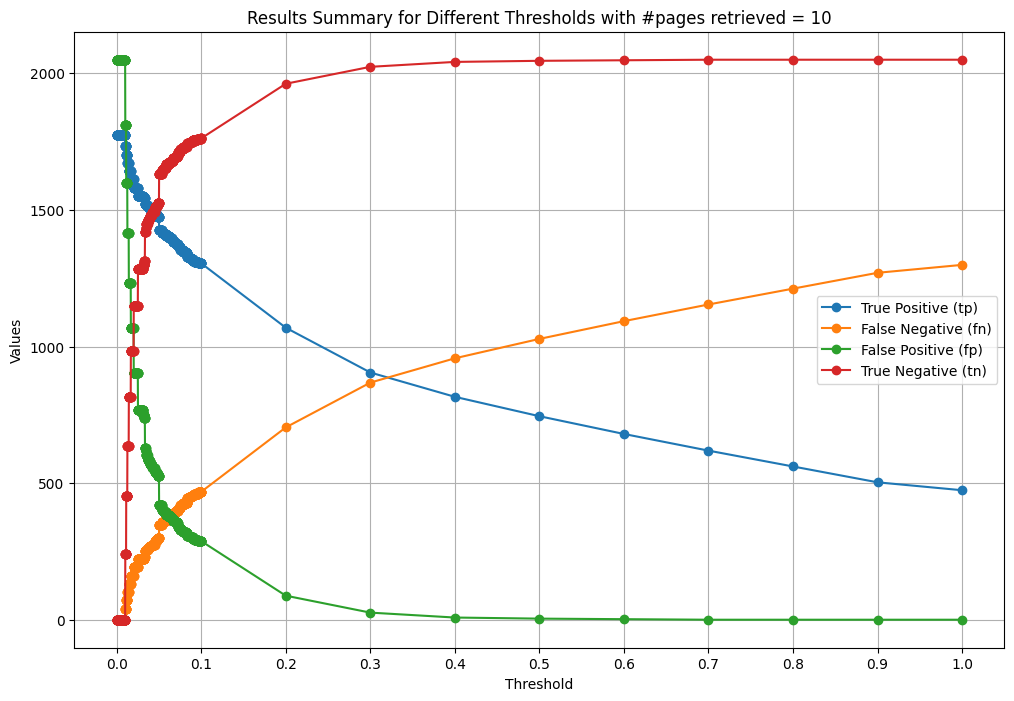

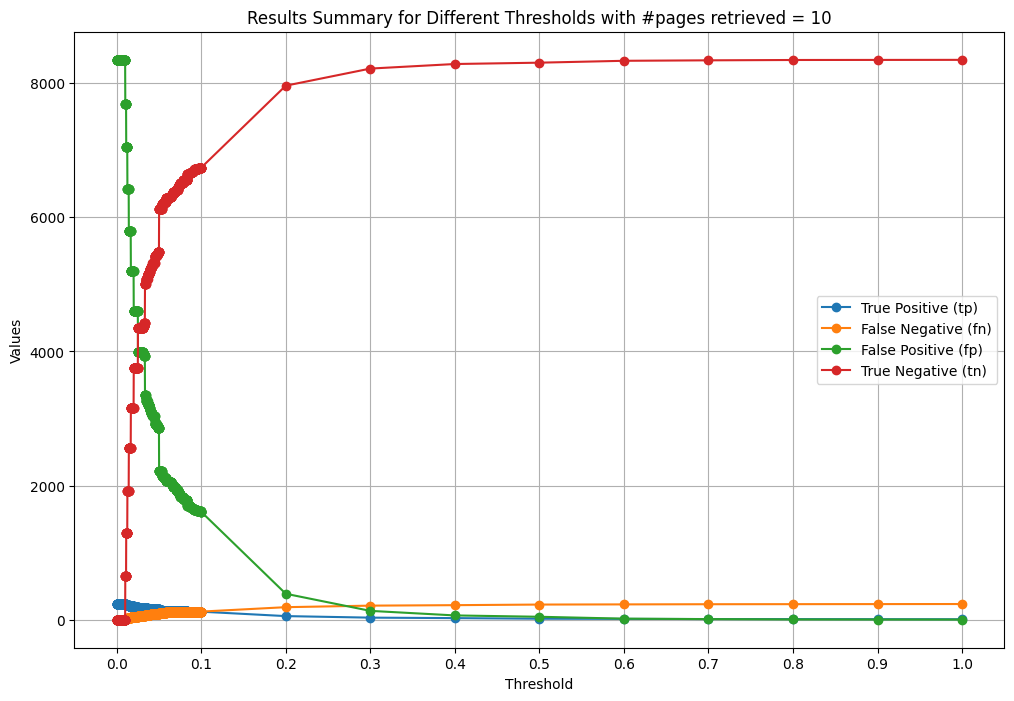

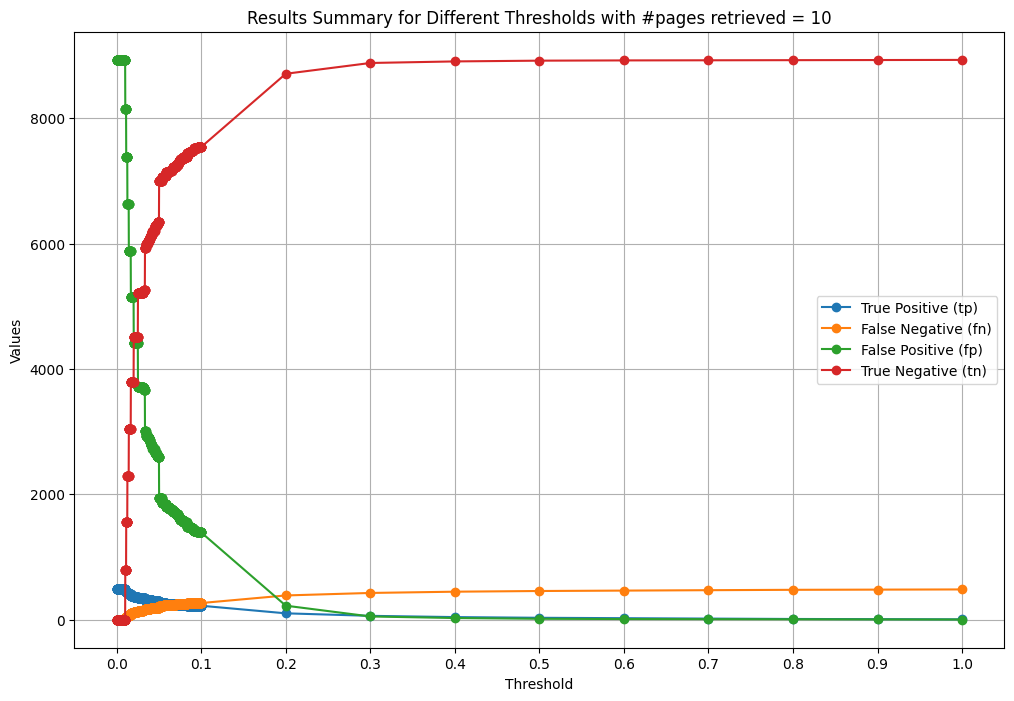

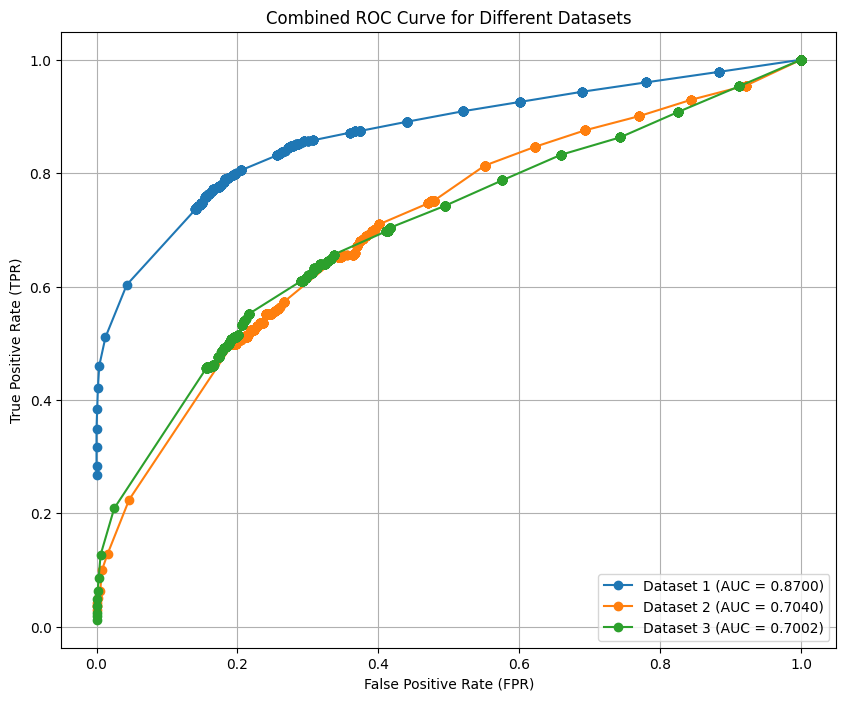

In [16]:
data_sets = [results_summary_x1_10, results_summary_x2_10, results_summary_x3_10]
labels = ["Dataset 1", "Dataset 2", "Dataset 3"]

# Define variables
thresholds = [i / 10 for i in range(11)]  # Define thresholds as needed
SAVE_FOLDER = 'results'  # Define the save folder path
RESULTS_FILE = 'example_results.json'  # Placeholder filename

# Ensure the save directory exists
os.makedirs(SAVE_FOLDER, exist_ok=True)

# Part 1: Plot tp, fn, fp, tn values against thresholds for each dataset
for i, (data, label) in enumerate(zip(data_sets, labels), start=1):
    results_df = pd.DataFrame(data)  # Convert data to DataFrame for plotting
    plt.figure(figsize=(12, 8))

    # Plot tp, fn, fp, tn values against thresholds
    plt.plot(results_df['threshold'], results_df['tp'], marker='o', label='True Positive (tp)')
    plt.plot(results_df['threshold'], results_df['fn'], marker='o', label='False Negative (fn)')
    plt.plot(results_df['threshold'], results_df['fp'], marker='o', label='False Positive (fp)')
    plt.plot(results_df['threshold'], results_df['tn'], marker='o', label='True Negative (tn)')

    plt.title(f'Results Summary for Different Thresholds with #pages retrieved = {10}')
    plt.xlabel('Threshold')
    plt.ylabel('Values')
    plt.xticks(thresholds)
    plt.grid(True)
    plt.legend()

    # Save each individual threshold plot
    save_path = os.path.join(SAVE_FOLDER, f"weighted_frequency_{RESULTS_FILE.split('.')[0]}_{label}.png")
    plt.savefig(save_path)
    plt.show()
    plt.close()

# Part 2: Combined ROC plot for all datasets
plt.figure(figsize=(10, 8))

for data, label in zip(data_sets, labels):
    # Calculate TPR and FPR for combined ROC plot
    tpr = [d['tp'] / (d['tp'] + d['fn']) if (d['tp'] + d['fn']) != 0 else 0 for d in data]
    fpr = [d['fp'] / (d['fp'] + d['tn']) if (d['fp'] + d['tn']) != 0 else 0 for d in data]

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot each ROC curve on the combined plot
    plt.plot(fpr, tpr, marker='o', label=f'{label} (AUC = {roc_auc:.4f})')

# Finalize the combined ROC plot
plt.title('Combined ROC Curve for Different Datasets')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(True)
plt.legend(loc='lower right')

# Save the combined ROC plot
save_path_combined_roc = os.path.join(SAVE_FOLDER, "combined_roc_curve.png")
plt.savefig(save_path_combined_roc)
plt.show()
plt.close()